In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

In [2]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'

# *Assignment Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

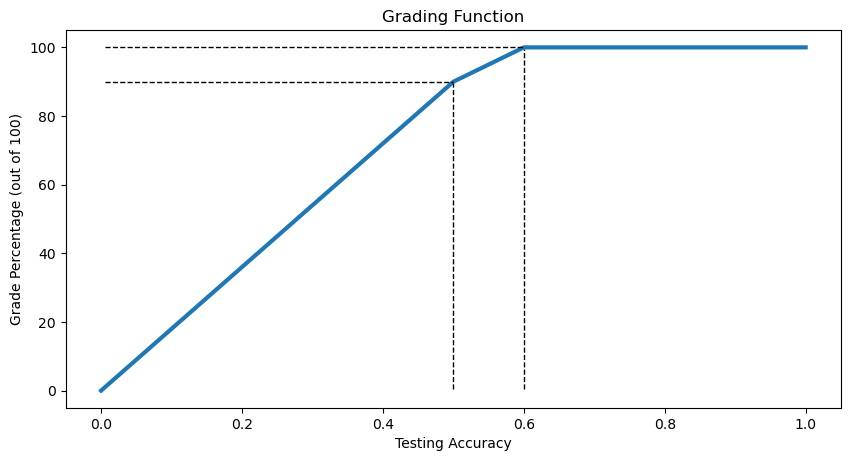

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# <span style="color:red">Important Notes</span>

You **should** read these notes before starting as these notes include crucial information about what is expected from you.

1. **Use Pytorch**: The autograder will only accept pytorch models.

  * Pytorch's CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html is the best starting point for this assignment. However, we will not prohibit using or learning from any other tutorial you may find online.


2. **No Downloads**: The coursera machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.


3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Do not place these file under any newly created directory.
  * The trained model may **not exceed 1 MB** in size.


4. **Model Class Naming**: The neural models in the pytorch library are subclasses of the `torch.nn.Module` class. While you can define any architecture as you please, your `torch.nn.Module` must be named `Net` exactly. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


5. **Grading Reference Pre-processing**: We will use a specific randomized transformation for grading that can be found in the `Autograding and Final Tests` section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

6. **Training Rules**: You are able to make the following decisions about your model:

  * You **can** choose and change your architecture as you please. 
      * You can have shallow networks, or deep ones.
      * You can customize the number of neural units in each layer and the depth of the network.
      * You are free to use convolutional, and non-convolutional layers.
      * You can employ batch normalization if you would like to.
      * You can use any type of non-linear layers as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of pooling layers you deem appropriate.
      * etc.
   * You **can** initialize your network using any of the methods described in `https://pytorch.org/docs/stable/nn.init.html`.
      * Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
      * You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).
   * You **can** use and customize any kind of optimization methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of loss function you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss. 
   * You **cannot** warm-start your network (i.e., you **cannot** use a pre-trained network).
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

In [4]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# your code here
#raise NotImplementedError

transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), shear=None, resample=0, fillcolor=0),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),   
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

cifar_root = '/home/jovyan/work/release/CNN-lib/data_cifar'
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root=cifar_root, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


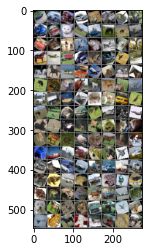

 bird   car truck   car  deer  ship  bird  bird truck truck   cat plane  ship horse  bird   cat   car   cat horse plane   dog  deer   dog horse horse plane truck   car  frog   car horse  bird horse horse  ship   car plane  frog horse horse  bird  frog  bird horse  deer  deer horse plane truck truck  ship  ship  bird   dog   car  bird  bird  deer  bird  ship  deer truck   cat plane   dog  bird  bird  deer  deer  frog   cat   cat  deer horse  frog  ship   cat horse  bird   dog   car  ship  ship truck  frog  frog plane plane   car   cat   car  ship truck   car truck truck   cat  frog plane  frog  ship  frog  bird  bird  frog  frog  frog  frog horse   car plane  frog   dog horse  deer   dog truck horse  bird  deer plane  frog horse   dog  deer truck  deer horse


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
#raise NotImplementedError

# Display one image from the training set
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# show images
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [6]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# your code here
#raise NotImplementedError

# CIFAR-10 is RGB and 32x32 pixels with 10 classes
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # attempting a 5 layer model for accuracy while staying compact
        # we're use batch normalization in early layers where it has more impact (improves convergence and generalization)
        # we're not using it in later layers to conserve space since we have a 1MB model limit
        
        self.conv1 = nn.Conv2d(3, 12, 3, padding=1)        
        self.conv2 = nn.Conv2d(12, 24, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(24)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(24, 48, 3, padding=1)
        self.conv4 = nn.Conv2d(48, 72, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(72, 72, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
                
        self.dropout = nn.Dropout(0.3) # helps with overfitting
                    
        self.fc1 = nn.Linear(72 * 4 * 4, 84) # flattening to 84 neurons is emperical to get under the 1MB size limit
        self.fc2 = nn.Linear(84, 10)        

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

You can define the neural architecture and instantiate it in this cell.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [7]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here
#raise NotImplementedError

model = Net()

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 1.4 Defining The Loss Function and The Optimizer

In [8]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
#raise NotImplementedError

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # adaptive moment estimation
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

You can define the loss function and the optimizer of interest here.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [9]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    #raise NotImplementedError
       
    best_val_loss = float('inf')
    best_model_state = None
        
    num_epochs = 20 
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # loop over the training data
        for i, (inputs, labels) in enumerate(trainloader, 0):

            optimizer.zero_grad() # zero the gradients            

            # forward pass, backward pass, optimize
            outputs = model(inputs) 
            loss = criterion(outputs, labels)            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # track accuracy
            _, predicted = torch.max(outputs.data, 1)  # get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # average loss and accuracy for this epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total

        # validate the model and compute the validation loss
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(testloader)
        
        # save the best model, this helps us avoid a model that overfits later
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        # reduce LR if validation loss stops improving
        scheduler.step(avg_val_loss)  

        # print progress
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    print('Finished Training!')

You can define the training loop and forward-backward propagation here.
Epoch 1/20, Loss: 1.7248, Accuracy: 36.39%
Epoch 2/20, Loss: 1.4135, Accuracy: 49.09%
Epoch 3/20, Loss: 1.2570, Accuracy: 55.00%
Epoch 4/20, Loss: 1.1629, Accuracy: 59.15%
Epoch 5/20, Loss: 1.0909, Accuracy: 61.56%
Epoch 6/20, Loss: 1.0400, Accuracy: 63.43%
Epoch 7/20, Loss: 1.0014, Accuracy: 65.14%
Epoch 8/20, Loss: 0.9574, Accuracy: 66.49%
Epoch 9/20, Loss: 0.9387, Accuracy: 67.40%
Epoch 10/20, Loss: 0.9053, Accuracy: 68.50%
Epoch 11/20, Loss: 0.8794, Accuracy: 69.43%
Epoch 12/20, Loss: 0.8571, Accuracy: 70.23%
Epoch 13/20, Loss: 0.8433, Accuracy: 70.58%
Epoch 14/20, Loss: 0.8304, Accuracy: 71.12%
Epoch 15/20, Loss: 0.8129, Accuracy: 71.87%
Epoch 16/20, Loss: 0.8010, Accuracy: 72.23%
Epoch 17/20, Loss: 0.7865, Accuracy: 72.61%
Epoch 18/20, Loss: 0.7826, Accuracy: 72.95%
Epoch 19/20, Loss: 0.7567, Accuracy: 73.82%
Epoch 20/20, Loss: 0.7557, Accuracy: 73.92%
Finished Training!


# 1.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [10]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

if perform_computation:
    # your code here
    #raise NotImplementedError
        
    torch.save(best_model_state, './cifar_net.pth')    
    print("Trained model saved as 'cifar_net.pth'. Model size in KB:", os.path.getsize("./cifar_net.pth") / 1024)    

Here you should store the model at "./cifar_net.pth" .
Trained model saved as 'cifar_net.pth'. Model size in KB: 745.7802734375


# 1.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


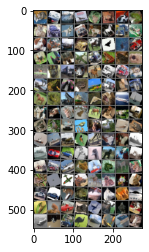

  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat


In [11]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

# ensure the model is loaded from the saved model so we know what the autograder will see
if 'trained_model' in globals():
    del trained_model
trained_model = Net()
trained_model.load_state_dict(torch.load('./cifar_net.pth'))

trained_model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [12]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

trained_model.eval()
correct = 0
total = 0

with torch.no_grad():  # disable gradient calculation during evaluation
    for inputs, labels in testloader:
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Overall Test Accuracy: {accuracy:.2f}%')


Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Overall Test Accuracy: 72.94%


In [13]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

trained_model.eval()
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():  # disable gradient calculation during evaluation
    for inputs, labels in testloader:
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of {classes[i]}: {accuracy:.2f}%')

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of plane: 74.10%
Accuracy of car: 82.60%
Accuracy of bird: 62.70%
Accuracy of cat: 49.40%
Accuracy of deer: 73.20%
Accuracy of dog: 70.80%
Accuracy of frog: 73.20%
Accuracy of horse: 81.90%
Accuracy of ship: 79.90%
Accuracy of truck: 80.60%


## 1.8 Autograding and Final Tests

In [14]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

cifar_root = '/home/jovyan/work/release/CNN-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of plane : 74 %
Accuracy of   car : 81 %
Accuracy of  bird : 62 %
Accuracy of   cat : 50 %
Accuracy of  deer : 71 %
Accuracy of   dog : 69 %
Accuracy of  frog : 71 %
Accuracy of horse : 81 %
Accuracy of  ship : 81 %
Accuracy of truck : 82 %
----------
Overall Testing Accuracy: 72.52 %%


In [15]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [16]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = list(str(i) for i in range(10))

# your code here
#raise NotImplementedError

transform = transforms.Compose([
    transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.0), shear=None, resample=0, fillcolor=0),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),    
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_root = '/home/jovyan/work/release/CNN-lib/data_mnist'
batch_size = 64

trainset = torchvision.datasets.MNIST(root=mnist_root, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root=mnist_root, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


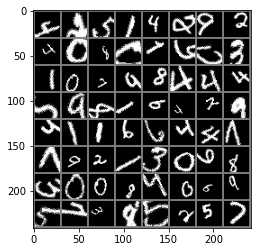

    4     2     5     1     4     2     9     2     4     0


In [17]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# your code here
#raise NotImplementedError

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

In [18]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)


# your code here
#raise NotImplementedError

#import torch.nn.init as init

# MNIST is grayscale and 28x28 poxels
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16) # improves convergence and generalization
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3) # helps with overfitting
                        
        self.fc1 = nn.Linear(32 * 7 * 7, 64) # flatten feature map into 64 neurons
        self.fc2 = nn.Linear(64, 10) # 10 classes
        
        self.initialize_weights()
        
    def initialize_weights(self):
        
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)        
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')

        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)        
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
                
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

You can define the neural architecture and instantiate it in this cell.


# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [19]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here
#raise NotImplementedError

model = Net()

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 2.4 Defining The Loss Function and The Optimizer

In [20]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# your code here
#raise NotImplementedError

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

You can define the loss function and the optimizer of interest here.


# 2.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [21]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # your code here
    #raise NotImplementedError
    
    best_val_loss = float('inf')
    best_model_state = None
    
    num_epochs = 10
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # loop over the training data
        for i, (inputs, labels) in enumerate(trainloader, 0):

            optimizer.zero_grad() # zero the gradients            

            # forward pass, backward pass, optimize
            outputs = model(inputs) 
            loss = criterion(outputs, labels)            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # track accuracy
            _, predicted = torch.max(outputs.data, 1)  # get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # average loss and accuracy for this epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total

        # validate the model and compute the validation loss
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(testloader)
        
        # save the best model, this helps us avoid a model that overfits later
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

        # reduce LR if validation loss stops improving
        scheduler.step(avg_val_loss)  

        # print progress
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    print('Finished Training!')

You can define the training loop and forward-backward propagation here.
Epoch 1/10, Loss: 1.5817, Accuracy: 44.29%
Epoch 2/10, Loss: 1.1417, Accuracy: 60.82%
Epoch 3/10, Loss: 0.9760, Accuracy: 66.96%
Epoch 4/10, Loss: 0.8740, Accuracy: 70.48%
Epoch 5/10, Loss: 0.8076, Accuracy: 72.97%
Epoch 6/10, Loss: 0.7591, Accuracy: 74.89%
Epoch 7/10, Loss: 0.7153, Accuracy: 76.57%
Epoch 8/10, Loss: 0.6635, Accuracy: 78.39%
Epoch 9/10, Loss: 0.6425, Accuracy: 79.14%
Epoch 10/10, Loss: 0.6067, Accuracy: 80.30%
Finished Training!


# 2.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [22]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

if perform_computation:
    # your code here
    #raise NotImplementedError
        
    # save the (best) model
    torch.save(best_model_state, './mnist_net.pth')
    print("Trained model saved as 'mnist_net.pth'. Model size in KB:", os.path.getsize("./mnist_net.pth") / 1024)    

Here you should store the model at "./mnist_net.pth" .
Trained model saved as 'mnist_net.pth'. Model size in KB: 420.0341796875


# 2.7 Evaluating the Trained Model

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


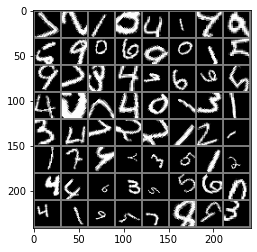

    7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3


In [23]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError
# ensure the model is loaded from the saved model so we know what the autograder will see
if 'trained_model' in globals():
    del trained_model
trained_model = Net()
trained_model.load_state_dict(torch.load('./mnist_net.pth'))

trained_model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [24]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

trained_model.eval()
correct = 0
total = 0

with torch.no_grad():  # disable gradient calculation during evaluation
    for inputs, labels in testloader:
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Overall Test Accuracy: {accuracy:.2f}%')

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Overall Test Accuracy: 87.93%


In [25]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# your code here
#raise NotImplementedError

trained_model.eval()
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():  # disable gradient calculation during evaluation
    for inputs, labels in testloader:
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of {classes[i]}: {accuracy:.2f}%')

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy of 0: 92.65%
Accuracy of 1: 98.15%
Accuracy of 2: 80.43%
Accuracy of 3: 91.78%
Accuracy of 4: 86.25%
Accuracy of 5: 87.89%
Accuracy of 6: 92.90%
Accuracy of 7: 84.82%
Accuracy of 8: 84.29%
Accuracy of 9: 84.74%


## 2.8 Autograding and Final Tests

In [26]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                 'Make sure you read and follow the instructions provided as Important Notes' + \
                                 '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. ' + \
                                      'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/home/jovyan/work/release/CNN-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of     0 : 92 %
Accuracy of     1 : 97 %
Accuracy of     2 : 81 %
Accuracy of     3 : 91 %
Accuracy of     4 : 87 %
Accuracy of     5 : 87 %
Accuracy of     6 : 93 %
Accuracy of     7 : 84 %
Accuracy of     8 : 82 %
Accuracy of     9 : 84 %
----------
Overall Testing Accuracy: 88.41 %%


In [27]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"
